# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [8]:

# using the SQLite Table to read data.

import os 

con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 6000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (6000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [9]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [10]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [11]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [12]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [14]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(5979, 10)

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.65

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [17]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(5979, 10)


1    5014
0     965
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I Love these chips for its unique taste and incredible crispy texture. Used to get them at Henry's in San Diego, CA before we moved out of there and have been ordering them from Amazon since. Running out of them constantly!
I dont like the taste of this at all.  I have some other fennel tea from another company not on amazon and it is fantastic.  Cant remember exact name but think it is something like MB - is a french company and I got it in canada and by mail order after that.  It is much better to my taste.  Never dreamed there would be this much variance among fennel seeds as only ingredient.
If you are a peanut lover, these are for you. Much larger than cocktail peanuts. Six people on my Christmas gift list ask for thes

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I Love these chips for its unique taste and incredible crispy texture. Used to get them at Henry's in San Diego, CA before we moved out of there and have been ordering them from Amazon since. Running out of them constantly!
I dont like the taste of this at all.  I have some other fennel tea from another company not on amazon and it is fantastic.  Cant remember exact name but think it is something like MB - is a french company and I got it in canada and by mail order after that.  It is much better to my taste.  Never dreamed there would be this much variance among fennel seeds as only ingredient.
If you are a peanut lover, these are for you. Much larger than cocktail peanuts. Six people on my Christmas gift list ask for these every year!!


In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I dont like the taste of this at all.  I have some other fennel tea from another company not on amazon and it is fantastic.  Cant remember exact name but think it is something like MB - is a french company and I got it in canada and by mail order after that.  It is much better to my taste.  Never dreamed there would be this much variance among fennel seeds as only ingredient.


In [25]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I dont like the taste of this at all I have some other fennel tea from another company not on amazon and it is fantastic Cant remember exact name but think it is something like MB is a french company and I got it in canada and by mail order after that It is much better to my taste Never dreamed there would be this much variance among fennel seeds as only ingredient 


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 5979/5979 [00:03<00:00, 1766.75it/s]


In [29]:
preprocessed_reviews[1500]

'dont like taste fennel tea another company not amazon fantastic cant remember exact name think something like mb french company got canada mail order much better taste never dreamed would much variance among fennel seeds ingredient'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [30]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [183]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5979, 14318)
the number of unique words  14318


## [4.2] Bi-Grams and n-Grams.

In [33]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5979, 3711)
the number of unique words including both unigrams and bigrams  3711


## [4.3] TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely delicious']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5979, 3711)
the number of unique words including both unigrams and bigrams  3711


## [4.4] Word2Vec

In [35]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [36]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9887293577194214), ('think', 0.9823833703994751), ('summary', 0.9823787212371826), ('alternative', 0.9811113476753235), ('right', 0.9804012179374695), ('hurt', 0.9803661108016968), ('especially', 0.9803148508071899), ('overall', 0.9802097082138062), ('either', 0.98005211353302), ('bad', 0.9796010255813599)]
[('teas', 0.9987434148788452), ('community', 0.9985976219177246), ('true', 0.9983398914337158), ('mustard', 0.9982709884643555), ('cafe', 0.9982611536979675), ('prefer', 0.9982181787490845), ('disappointing', 0.9981682896614075), ('french', 0.998084545135498), ('miss', 0.9980801939964294), ('thus', 0.9980640411376953)]


In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4278
sample words  ['product', 'available', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'seasons', 'ca', 'not', 'beat', 'great', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5979/5979 [00:10<00:00, 596.14it/s]

5979
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5979/5979 [00:53<00:00, 111.66it/s]


# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

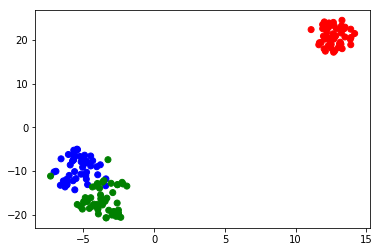

In [41]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

## [5.1] Applying TSNE on Text BOW vectors

The variable that contains the BOW implementation is "final_counts" which has been obtained after all the text 
preprocessing steps performed and after applying the BOW implementation.

In [59]:
type(final_counts)

scipy.sparse.csr.csr_matrix

This is basically a sparse matrix representation with majority of the elements being 0 and only a few elements being
non-zero. 

In [62]:
print(final_counts.shape)

#I have taken 6k points for TSNE.

(5979, 14318)


The BOW representation matrix has a total of 5979 rows (each row for each review) and a total of 14318 columns
representing the total number of unique words present in the Corpus. 

Therefore the first step over here would be to convert this sparse matrix representation into a dense
matrix representation, since TSNE only inputs dense matrices. 

In [67]:
#todense() is a function used in scipy to convert a sparse matrix to a dense matrix. 
BOW = final_counts.todense()
BOW.shape

(5979, 14318)

The dimensionality of the dense matrix representation is also the same as the sparse matrix. However, the 
difference lies in the fact that for the dense matrix representation, the non-zero elements are stored as 
a dictionary which considerably reduces the time and space complexity.

Now I will also need to apply column standardization first before I can work on TSNE.

In [84]:
from sklearn.preprocessing import StandardScaler
standardized_bow = StandardScaler().fit_transform(BOW)
print(standardized_bow.shape)

#Now all the columns would have mean = 0 and standard deviation =1. 

(5979, 14318)


Now I can finally work on T-SNE with a considerably large value of step-size being fixed and varying values of
perplexity.

In [91]:
final.head(5)
final['Score'].value_counts()

1    5014
0     965
Name: Score, dtype: int64

# TSNE on BOW : Perplexity=5, Number of Iterations=1000

First I will have a look at TSNE on BOW using a small value of perplexity, such as 5 and set the number of iterations
to be equal to the default value of 1000. 

In [154]:
from sklearn.manifold import TSNE

BOW_model1 = TSNE(n_components=2, perplexity=5,n_iter=1000,random_state=0)
BOW_TSNE1 = BOW_model1.fit_transform(standardized_bow)

In [155]:
print(BOW_TSNE1.shape)

(5979, 2)


Therefore, here I have successfully carried out the dimensionality reduction from 14,318 to 2 dimensions. Now I need
to add 'Score' as a column to this dataset in order to plot the same using "Seaborn".

In [156]:
labels = final['Score'].map({1:"Positive",0:"Negative"}).astype(str)

In [157]:
print(BOW_TSNE1.shape)

(5979, 2)


In [158]:
print(labels.shape)

(5979,)


In [159]:
BOW_TSNE1 = np.vstack((BOW_TSNE1.T,labels)).T

In [160]:
BOW_DF1 = pd.DataFrame(data=BOW_TSNE1,columns=("Dim_1","Dim_2","Score"))
print(BOW_DF1.head(5))
print(BOW_DF1.shape)

     Dim_1    Dim_2     Score
0  2.84063  55.5353  Positive
1  2.83988  55.5245  Positive
2  69.9908 -34.0653  Positive
3 -12.5035 -16.5918  Positive
4  82.3461  -58.677  Positive
(5979, 3)


This is the final dataset that I have obtained for this particular perplexity value on which I will plot the graph.

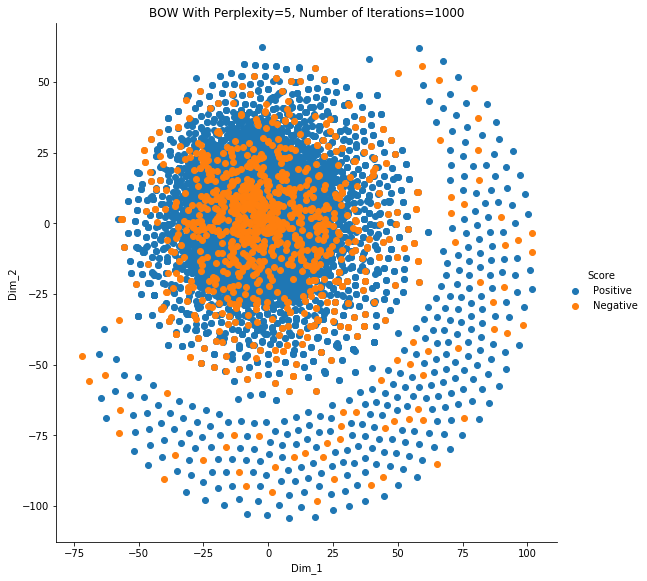

In [337]:
import seaborn as sns
sns.FacetGrid(data=BOW_DF1,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("BOW With Perplexity=5, Number of Iterations=1000")
plt.show()

# TSNE on BOW : Perplexity=30, Number of Iterations=1000

In [162]:
BOW_model2 = TSNE(n_components=2, perplexity=30,n_iter=1000,random_state=0)
BOW_TSNE2 = BOW_model2.fit_transform(standardized_bow)

In [163]:
print(BOW_TSNE2.shape)

(5979, 2)


In [164]:
BOW_TSNE2 = np.vstack((BOW_TSNE2.T,labels)).T

In [165]:
BOW_DF2 = pd.DataFrame(data=BOW_TSNE2,columns=("Dim_1","Dim_2","Score"))
print(BOW_DF2.head(5))
print(BOW_DF2.shape)

     Dim_1    Dim_2     Score
0  11.0247 -25.6975  Positive
1  11.0167 -25.6788  Positive
2  50.5197 -94.4213  Positive
3  4.37154 -15.5062  Positive
4    84.45 -48.3507  Positive
(5979, 3)


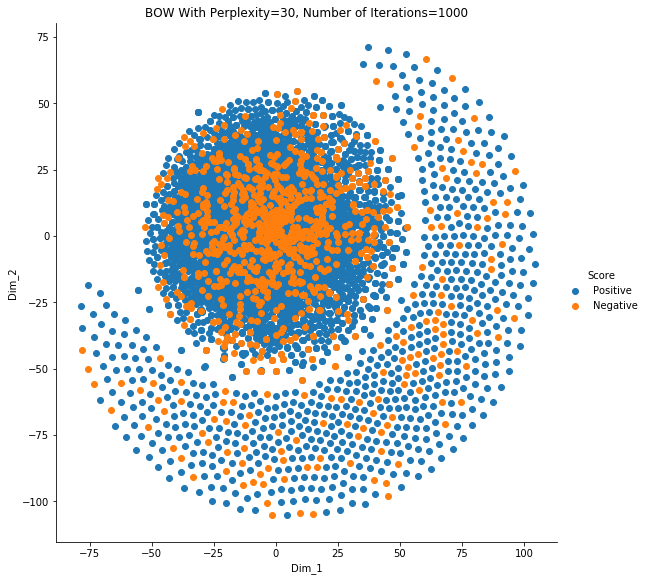

In [336]:
import seaborn as sns
sns.FacetGrid(data=BOW_DF2,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("BOW With Perplexity=30, Number of Iterations=1000")
plt.show()

# TSNE on BOW : Perplexity=30, Number of Iterations=5500

In [167]:
from sklearn.manifold import TSNE

BOW_model3 = TSNE(n_components=2, perplexity=30,n_iter=5500,random_state=0)
BOW_TSNE3 = BOW_model3.fit_transform(standardized_bow)

In [168]:
print(BOW_TSNE3.shape)

(5979, 2)


In [169]:
BOW_TSNE3 = np.vstack((BOW_TSNE3.T,labels)).T

In [170]:
BOW_DF3 = pd.DataFrame(data=BOW_TSNE3,columns=("Dim_1","Dim_2","Score"))
print(BOW_DF3.head(5))
print(BOW_DF3.shape)

     Dim_1    Dim_2     Score
0  16.2351 -37.8208  Positive
1  16.2284 -37.8068  Positive
2  131.028 -248.347  Positive
3  9.38089 -17.3108  Positive
4  225.029 -117.119  Positive
(5979, 3)


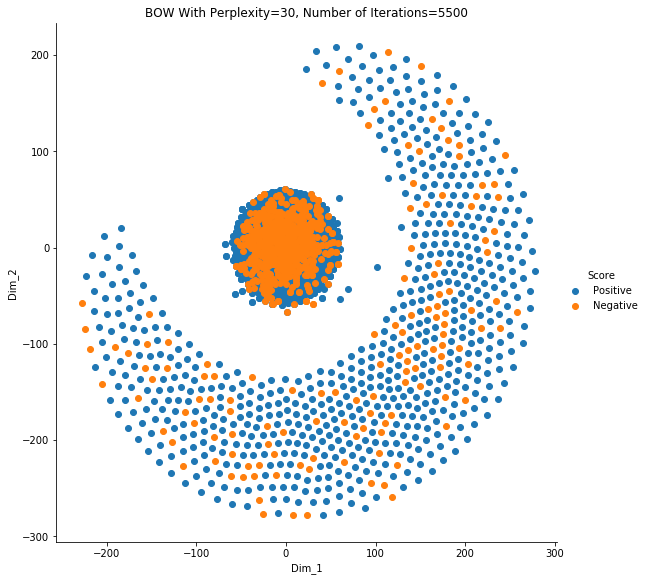

In [335]:
import seaborn as sns
sns.FacetGrid(data=BOW_DF3,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("BOW With Perplexity=30, Number of Iterations=5500")
plt.show()

# TSNE on BOW : Perplexity=50, Number of Iterations=10,000

Here, alongwith the other parameters, I have also made n_iter_without_progress = 500, which means anytime before
the 10,000 iterations are completed, if 500 iterations are resulting in the plot not changing at all, the loop will
be exited.

In [172]:
from sklearn.manifold import TSNE

BOW_model4 = TSNE(n_components=2, perplexity=50,n_iter=10000,n_iter_without_progress=500,random_state=0)
BOW_TSNE4 = BOW_model4.fit_transform(standardized_bow)

In [173]:
print(BOW_TSNE4.shape)

(5979, 2)


In [174]:
BOW_TSNE4 = np.vstack((BOW_TSNE4.T,labels)).T

In [175]:
BOW_DF4 = pd.DataFrame(data=BOW_TSNE4,columns=("Dim_1","Dim_2","Score"))
print(BOW_DF4.head(5))
print(BOW_DF4.shape)

     Dim_1    Dim_2     Score
0  34.9715 -31.2913  Positive
1  34.9598  -31.282  Positive
2  275.248 -145.279  Positive
3  281.797  68.1296  Positive
4  283.961 -17.6504  Positive
(5979, 3)


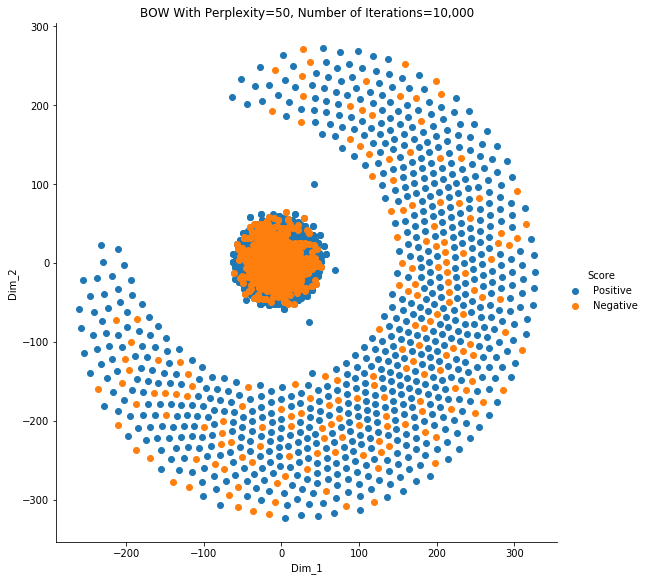

In [334]:
import seaborn as sns
sns.FacetGrid(data=BOW_DF4,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("BOW With Perplexity=50, Number of Iterations=10,000")
plt.show()

# TSNE on BOW : Perplexity=300, Number of Iterations=10,000

Therefore no matter how many different values of perplexity and iterations I have tried so far for t-SNE on the BOW approach, I have not obtained a plot that even remotely separates the Positive and Negative points.

Finally, I read that on average people set the value of perplexity = 5 % of the data size. 
{Source: https://stats.stackexchange.com/questions/245168/choosing-the-hyperparameters-using-t-sne-for-classification}

Here, the data size in my case = 5979. 

5% of 5979 = approx. 298 

Therefore, finally for the BOW approach, I will try with a much higher value of perplexity and see if it helps my case although since BOW is the most basic approach, it seems rather unlikely.


In [177]:
from sklearn.manifold import TSNE

BOW_model5 = TSNE(n_components=2, perplexity=300,n_iter=10000,n_iter_without_progress=500,random_state=0)
BOW_TSNE5 = BOW_model5.fit_transform(standardized_bow)

In [178]:
print(BOW_TSNE5.shape)

(5979, 2)


In [179]:
BOW_TSNE5 = np.vstack((BOW_TSNE5.T,labels)).T

In [180]:
BOW_DF5 = pd.DataFrame(data=BOW_TSNE5,columns=("Dim_1","Dim_2","Score"))
print(BOW_DF5.head(5))
print(BOW_DF5.shape)

     Dim_1    Dim_2     Score
0  33.2727 -24.3021  Positive
1  33.2546 -24.2896  Positive
2 -17.6789 -9.47198  Positive
3 -112.977  166.435  Positive
4   18.512  12.8943  Positive
(5979, 3)


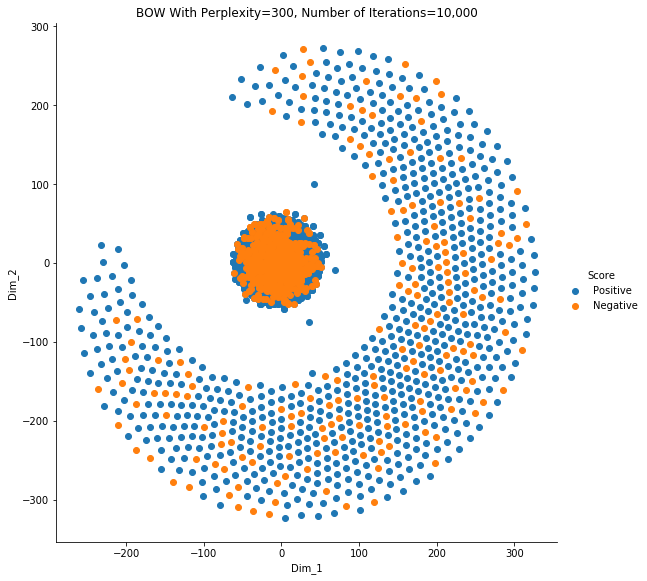

In [333]:
import seaborn as sns
sns.FacetGrid(data=BOW_DF4,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("BOW With Perplexity=300, Number of Iterations=10,000")
plt.show()

So, as expected for all varying values of Perplexity as well as step size, BOW Approach does a terrible job in 
separating the 2 class labels.

## [5.1] Applying TSNE on Text TFIDF vectors

The variable that contains the Text TFIDF implementation is "final_tf_idf" which has been obtained after all the text 
preprocessing steps have been performed and after applying the TFIDF implementation.

In [185]:
type(final_tf_idf)

scipy.sparse.csr.csr_matrix

Again, just like the BOW approach, TFIDF is also a sparse matrix representation with most of the elements in the
matrix being equal to zero. Again it needs to be converted into a dense matrix before I proceed with applying
TSNE on the same.

In [189]:
print(final_tf_idf.shape)

(5979, 3711)


In [190]:
#Converting into a dense matrix representation
#todense() is the function used in scipy to convert a sparse matrix into a dense matrix. 

TFIDF = final_tf_idf.todense()
TFIDF.shape

(5979, 3711)

The dimensionality of the dense matrix representation is also the same as the sparse matrix. However, the 
difference lies in the fact that for the dense matrix representation, the non-zero elements are stored as 
a dictionary which considerably reduces the time and space complexity.

Now I will first implement Column Standardization before I work on TSNE.

In [191]:
#Performing Column Standardization

from sklearn.preprocessing import StandardScaler
standardized_tfidf = StandardScaler().fit_transform(TFIDF)
print(standardized_tfidf.shape)

#Now, mean=0 and standard deviation =1. 

(5979, 3711)


Now I can work on TSNE for TFIDF Implementation with various values of Perplexity as well as step size.

# TSNE on TFIDF : Perplexity = 5, Number of Iterations = 1000

In [194]:
from sklearn.manifold import TSNE

tfidf_model1 = TSNE(n_components=2,perplexity=5,n_iter=1000,random_state=0)
tfidf_TSNE1 = tfidf_model1.fit_transform(standardized_tfidf)

In [195]:
print(tfidf_TSNE1.shape)

(5979, 2)


In [196]:
tfidf_TSNE1 = np.vstack((tfidf_TSNE1.T,labels)).T

In [197]:
tfidf_DF1 = pd.DataFrame(data=tfidf_TSNE1,columns=("Dim_1","Dim_2","Score"))
print(tfidf_DF1.head(5))
print(tfidf_DF1.shape)

      Dim_1     Dim_2     Score
0   1.16009   1.12661  Positive
1  -3.90861   2.00684  Positive
2 -0.618516   0.59965  Positive
3 -0.371132  -1.66792  Positive
4  0.912841  0.807863  Positive
(5979, 3)


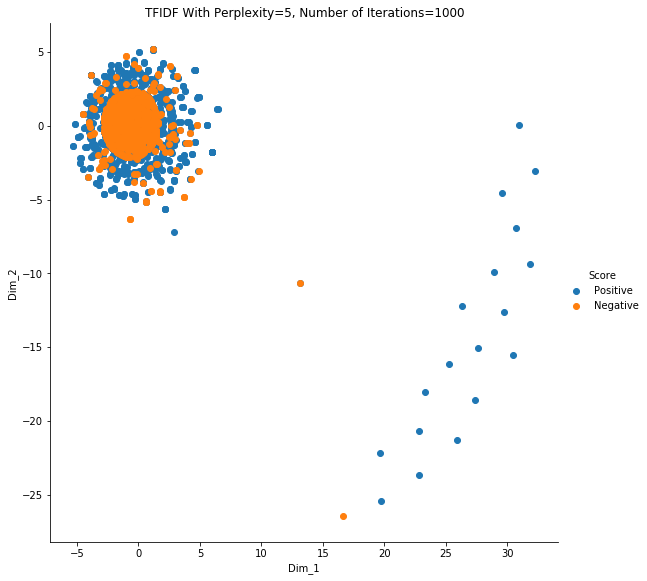

In [332]:
import seaborn as sns
sns.FacetGrid(data=tfidf_DF1,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF With Perplexity=5, Number of Iterations=1000")
plt.show()

# TSNE on TFIDF : Perplexity = 30, Number of Iterations = 5500

In [199]:

tfidf_model2 = TSNE(n_components=2,perplexity=30,n_iter=5500,random_state=0)
tfidf_TSNE2 = tfidf_model2.fit_transform(standardized_tfidf)

In [200]:
print(tfidf_TSNE2.shape)

(5979, 2)


In [201]:
tfidf_TSNE2 = np.vstack((tfidf_TSNE2.T,labels)).T

In [202]:
tfidf_DF2 = pd.DataFrame(data=tfidf_TSNE2,columns=("Dim_1","Dim_2","Score"))
print(tfidf_DF2.head(5))
print(tfidf_DF2.shape)

      Dim_1     Dim_2     Score
0  -2.10457  0.643815  Positive
1   1.72791  0.650412  Positive
2  0.376476   1.81288  Positive
3 -0.316581 -0.218711  Positive
4  0.109447   0.75033  Positive
(5979, 3)


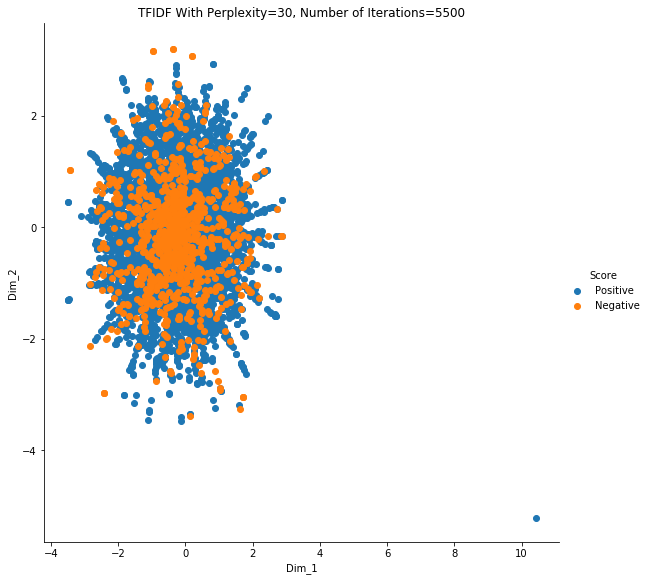

In [331]:
import seaborn as sns
sns.FacetGrid(data=tfidf_DF2,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF With Perplexity=30, Number of Iterations=5500")
plt.show()

# TSNE on TFIDF : Perplexity = 50, Number of Iterations = 2000

In [211]:

tfidf_model3 = TSNE(n_components=2,perplexity=50,n_iter=2000,random_state=0)
tfidf_TSNE3 = tfidf_model3.fit_transform(standardized_tfidf)

In [212]:
print(tfidf_TSNE3.shape)

(5979, 2)


In [213]:
tfidf_TSNE3 = np.vstack((tfidf_TSNE3.T,labels)).T

In [214]:
tfidf_DF3 = pd.DataFrame(data=tfidf_TSNE3,columns=("Dim_1","Dim_2","Score"))
print(tfidf_DF3.head(5))
print(tfidf_DF3.shape)

      Dim_1     Dim_2     Score
0  -2.07402  0.166656  Positive
1   2.43256  0.380792  Positive
2  0.670709   2.49109  Positive
3    1.1638  0.458991  Positive
4  0.284242  0.461556  Positive
(5979, 3)


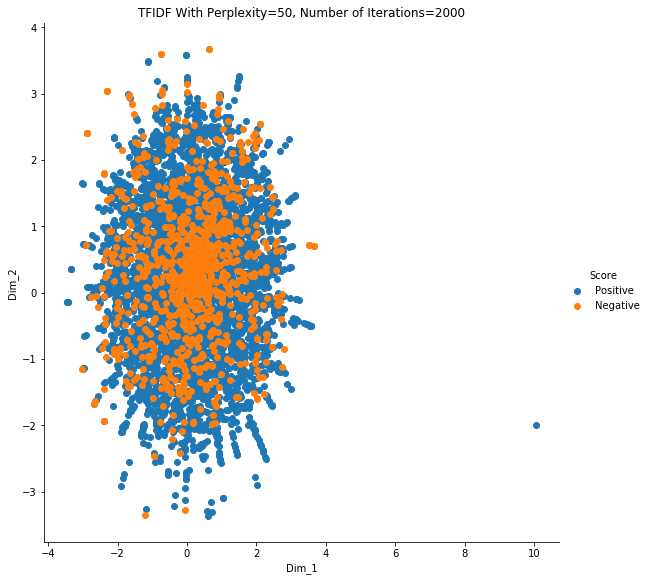

In [330]:
import seaborn as sns
sns.FacetGrid(data=tfidf_DF3,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF With Perplexity=50, Number of Iterations=2000")
plt.show()

# TSNE on TFIDF : Perplexity = 50, Number of Iterations = 10,000

In [216]:
tfidf_model4 = TSNE(n_components=2,perplexity=50,n_iter=10000,n_iter_without_progress=1000,random_state=0)
tfidf_TSNE4 = tfidf_model4.fit_transform(standardized_tfidf)

In [217]:
print(tfidf_TSNE4.shape)

(5979, 2)


In [218]:
tfidf_TSNE4 = np.vstack((tfidf_TSNE4.T,labels)).T

In [219]:
tfidf_DF4 = pd.DataFrame(data=tfidf_TSNE4,columns=("Dim_1","Dim_2","Score"))
print(tfidf_DF4.head(5))
print(tfidf_DF4.shape)

      Dim_1     Dim_2     Score
0   -1.6449 -0.330043  Positive
1   2.34184  0.785406  Positive
2  0.567642    2.5694  Positive
3   1.14944  0.327963  Positive
4  0.229775  0.373214  Positive
(5979, 3)


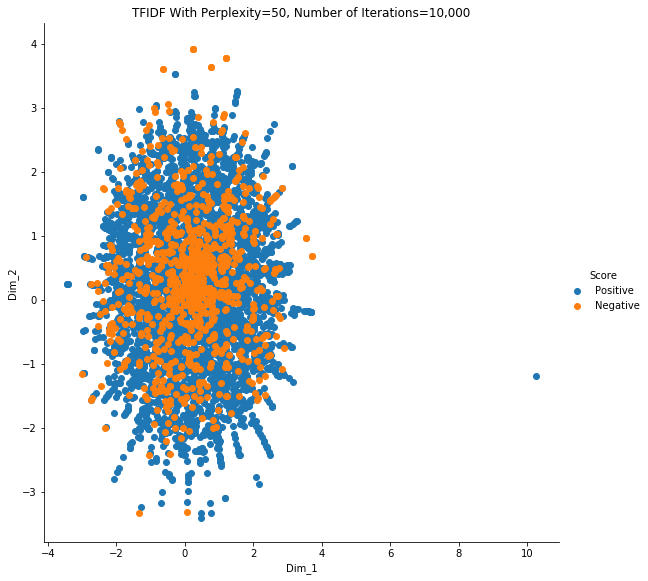

In [329]:
import seaborn as sns
sns.FacetGrid(data=tfidf_DF4,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF With Perplexity=50, Number of Iterations=10,000")
plt.show()

# TSNE on TFIDF : Perplexity = 300, Number of Iterations = 10,000

In [221]:
tfidf_model5 = TSNE(n_components=2,perplexity=300,n_iter=10000,n_iter_without_progress=1000,random_state=0)
tfidf_TSNE5 = tfidf_model5.fit_transform(standardized_tfidf)

In [222]:
print(tfidf_TSNE5.shape)

(5979, 2)


In [223]:
tfidf_TSNE5 = np.vstack((tfidf_TSNE5.T,labels)).T

In [224]:
tfidf_DF5 = pd.DataFrame(data=tfidf_TSNE5,columns=("Dim_1","Dim_2","Score"))
print(tfidf_DF5.head(5))
print(tfidf_DF5.shape)

      Dim_1      Dim_2     Score
0 -0.631012    1.00695  Positive
1    0.3011   0.247731  Positive
2 -0.839741    1.87856  Positive
3   1.54711  -0.750114  Positive
4  -1.23732  0.0922088  Positive
(5979, 3)


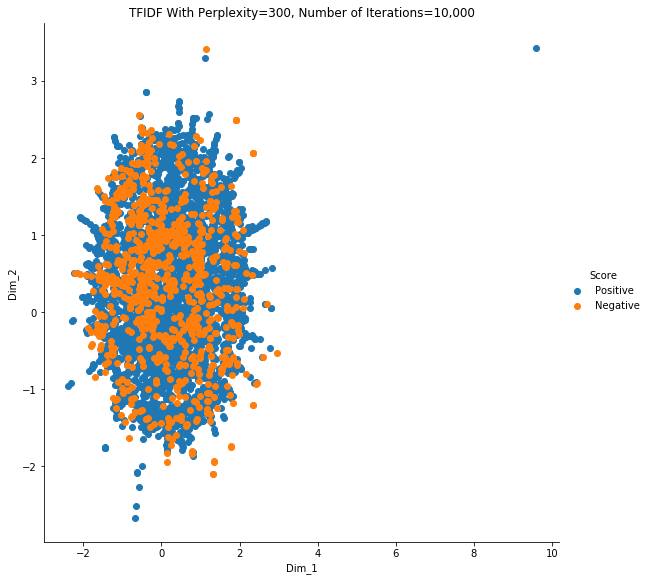

In [328]:
import seaborn as sns
sns.FacetGrid(data=tfidf_DF5,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF With Perplexity=300, Number of Iterations=10,000")
plt.show()

## [5.3] Applying TNSE on Text Avg W2V vectors

The variable that contains the Text Avg W2V Representation is "sent_vectors" obtained after the completion of all
the text preprocessing steps and after the Avg W2V implementation.

In [254]:
type(sent_vectors)

list

In [229]:
len(sent_vectors)

5979

Differing from the BOW as well as TFIDF representations which returned sparse matrices, Avg W2V is different as it
returns me a list of length 5979.


In [258]:
sent_vectors[0]

array([-0.05703185, -0.23206568,  0.14502353, -0.14157635, -0.51046246,
        0.55688779,  0.32838685,  0.13991607, -0.06681669,  0.29854992,
        0.47267885, -0.00370017, -0.25690637, -0.41701833,  0.23187369,
       -0.07570032,  0.37882946,  0.24361327,  0.13271049, -0.06462379,
       -0.33017787, -0.51655979,  0.81253935,  0.03329916, -0.019831  ,
        0.8039234 , -0.01478703,  0.18513408,  0.54002838,  0.07111467,
       -0.16202081,  0.18642075,  0.46631762,  0.34668125, -0.26345999,
       -0.297436  ,  0.02300675,  0.06880932,  0.43467439,  0.13271848,
       -0.28843465, -0.27869822,  0.08921298, -0.00908919,  0.03986808,
        0.02769456,  0.05354961, -0.18772326,  0.21384773,  0.45614208])

Word2Vec anyway returns us a dense matrix representation, and therefore there is no need to convert the same into a
dense matrix representation. 

However, column standardization is still important so that TSNE works smoothly. This has been performed as follows:

In [259]:
from sklearn.preprocessing import StandardScaler
standardized_AW2V = StandardScaler().fit_transform(sent_vectors)

In [246]:
print(standardized_AW2V.shape)

(5979, 50)


Now I basically have a 50 dimensional numpy array which needs to be embedded to a 2-dimensional space using TSNE.
(50 was the count of the number of dimensions that were specified for Word2Vec given the size of our data corpus)

# TSNE on Avg W2V : Perplexity = 5, Number of Iterations = 2000

In [269]:
from sklearn.manifold import TSNE

AW2V_model1 = TSNE(n_components=2,perplexity=5,n_iter=2000,random_state=0)
AW2V_TSNE1 = AW2V_model1.fit_transform(standardized_AW2V)

In [270]:
print(AW2V_TSNE1.shape)

(5979, 2)


Again, the dimensionality reduction has been successful from 50 dimensions to 2 dimensions, exactly what I needed.

In [271]:
AW2V_TSNE1 = np.vstack((AW2V_TSNE1.T,labels)).T

In [272]:
AW2V_DF1 = pd.DataFrame(data=AW2V_TSNE1,columns=("Dim_1","Dim_2","Score"))
print(AW2V_DF1.head(5))
print(AW2V_DF1.shape)

     Dim_1    Dim_2     Score
0 -122.916  26.7931  Positive
1 -124.541  26.0195  Positive
2 -140.089  7.08192  Positive
3  -119.95  21.3468  Positive
4 -128.142  3.74857  Positive
(5979, 3)


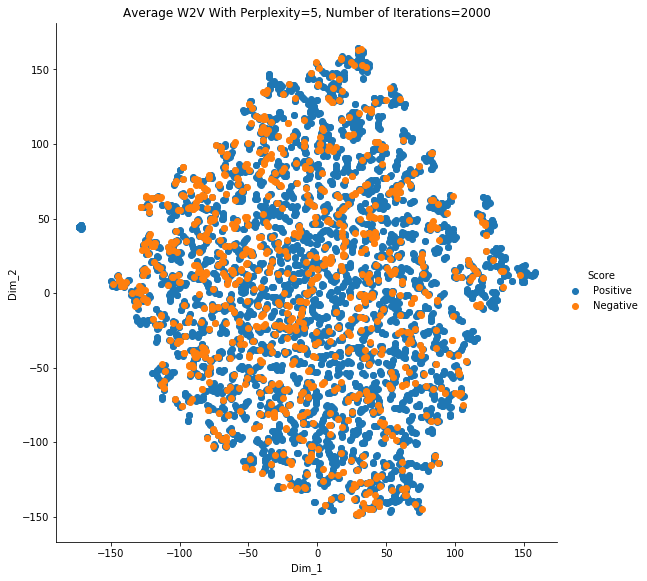

In [327]:
import seaborn as sns
sns.FacetGrid(data=AW2V_DF1,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("Average W2V With Perplexity=5, Number of Iterations=2000")
plt.show()

# TSNE on Avg W2V : Perplexity = 30, Number of Iterations = 10,000

In [291]:
AW2V_model2 = TSNE(n_components=2,perplexity=30,n_iter=10000,n_iter_without_progress=1000,random_state=0)
AW2V_TSNE2 = AW2V_model2.fit_transform(standardized_AW2V)

Again, here also I have set a very high value of step size and passed the parameter that if there is no progress 
in the visualization for 1000 continuous iterations, then terminate the loop.

In [292]:
print(AW2V_TSNE2.shape)

(5979, 2)


In [293]:
AW2V_TSNE2 = np.vstack((AW2V_TSNE2.T,labels)).T

In [294]:
AW2V_DF2 = pd.DataFrame(data=AW2V_TSNE2,columns=("Dim_1","Dim_2","Score"))
print(AW2V_DF2.head(5))
print(AW2V_DF2.shape)

     Dim_1    Dim_2     Score
0 -73.4158  46.4927  Positive
1 -75.5961   45.351  Positive
2  -89.321  30.7844  Positive
3  -73.489  40.7262  Positive
4 -83.8492  34.3285  Positive
(5979, 3)


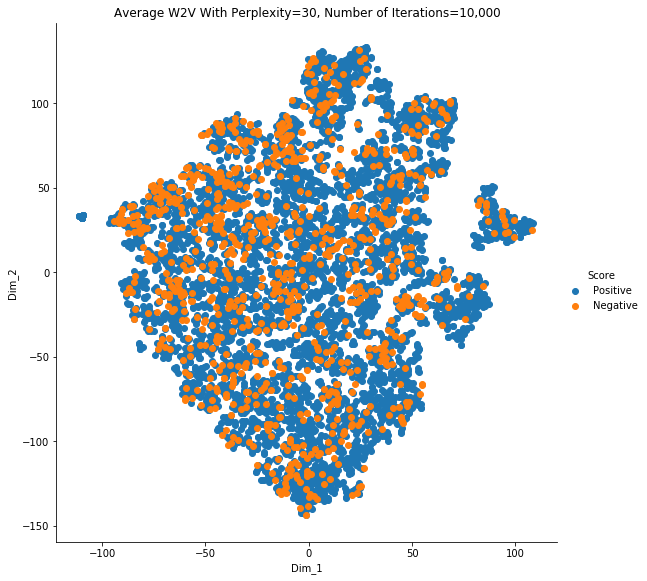

In [326]:
import seaborn as sns
sns.FacetGrid(data=AW2V_DF2,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("Average W2V With Perplexity=30, Number of Iterations=10,000")
plt.show()

# TSNE on Avg W2V : Perplexity = 50, Number of Iterations = 10,000

In [296]:
AW2V_model3 = TSNE(n_components=2,perplexity=50,n_iter=10000,n_iter_without_progress=1000,random_state=0)
AW2V_TSNE3 = AW2V_model3.fit_transform(standardized_AW2V)

In [297]:
print(AW2V_TSNE3.shape)

(5979, 2)


In [298]:
AW2V_TSNE3 = np.vstack((AW2V_TSNE3.T,labels)).T

In [299]:
AW2V_DF3 = pd.DataFrame(data=AW2V_TSNE3,columns=("Dim_1","Dim_2","Score"))
print(AW2V_DF3.head(5))
print(AW2V_DF3.shape)

     Dim_1    Dim_2     Score
0 -55.2174  31.2964  Positive
1 -56.8471  30.2298  Positive
2 -64.3292  19.4085  Positive
3 -54.8874  26.6795  Positive
4 -60.6783  22.6318  Positive
(5979, 3)


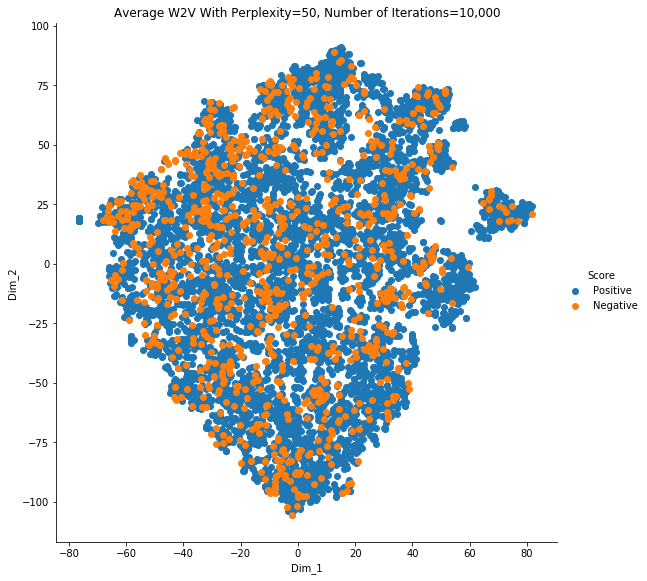

In [325]:
import seaborn as sns
sns.FacetGrid(data=AW2V_DF3,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("Average W2V With Perplexity=50, Number of Iterations=10,000")
plt.show()

Now I will try a random value of perplexity to see what does that give me as a result.

# TSNE on Avg W2V : Perplexity = 180, Number of Iterations = 10,000

In [301]:
AW2V_model4 = TSNE(n_components=2,perplexity=180,n_iter=10000,n_iter_without_progress=1000,random_state=0)
AW2V_TSNE4 = AW2V_model4.fit_transform(standardized_AW2V)

In [302]:
print(AW2V_TSNE4.shape)

(5979, 2)


In [303]:
AW2V_TSNE4 = np.vstack((AW2V_TSNE4.T,labels)).T

In [304]:
AW2V_DF4 = pd.DataFrame(data=AW2V_TSNE4,columns=("Dim_1","Dim_2","Score"))
print(AW2V_DF4.head(5))
print(AW2V_DF4.shape)

     Dim_1    Dim_2     Score
0 -18.5519  7.56345  Positive
1  -19.434  6.55371  Positive
2 -20.7771  2.80249  Positive
3 -18.7183  5.17442  Positive
4 -19.4862  3.93413  Positive
(5979, 3)


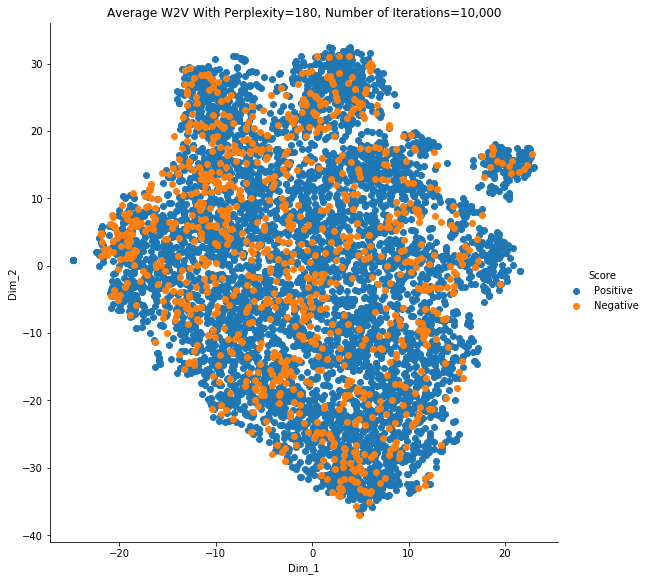

In [324]:
import seaborn as sns
sns.FacetGrid(data=AW2V_DF4,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("Average W2V With Perplexity=180, Number of Iterations=10,000")
plt.show()

Basically even for the different values of perplexity that we have tried and with a high enough value of the step 
size, the TSNE plot obtained is is not changing much. 

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

The variable that contains the Weighted W2V implementation is "tfidf_sent_vectors" which has been obtained after 
the entire text preprocessing has been carried out.

In [306]:
type(tfidf_sent_vectors)

list

In [307]:
len(tfidf_sent_vectors)

5979

In [308]:
tfidf_sent_vectors[0]

array([-0.07181407, -0.19929878,  0.14286958, -0.12755014, -0.42868752,
        0.48703076,  0.2771869 ,  0.11861013, -0.05463849,  0.24492784,
        0.39959753,  0.0008977 , -0.21864762, -0.36545952,  0.19043169,
       -0.05231103,  0.30488582,  0.21021077,  0.10827746, -0.06024283,
       -0.28990285, -0.43656656,  0.6980028 ,  0.01493119, -0.02633857,
        0.70044764, -0.02250358,  0.14193076,  0.45679612,  0.04595516,
       -0.13513797,  0.18521333,  0.40017933,  0.27523022, -0.23342776,
       -0.26146383,  0.00697366,  0.06690456,  0.36983069,  0.1015166 ,
       -0.25220925, -0.25548306,  0.07465367, -0.02749539,  0.04614894,
        0.01768587,  0.04439919, -0.16215477,  0.18575865,  0.38468328])

Again, in this case also there's no need to convert any of this to a dense matrix representation. 

However, column standardization is performed as follows:

In [309]:
standardized_tfidf_W2V = StandardScaler().fit_transform(tfidf_sent_vectors)

In [310]:
print(standardized_tfidf_W2V.shape)

(5979, 50)


Now I can build TSNE models on the same to carry out dimensionality reduction. 

# TSNE on TFIDF W2V : Perplexity = 5, Number of Iterations = 10,000

In this scenario also, for all the models I am taking a very large step size of 10,000 and passing the parameter
such that when there are 1000 iterations such that there is no progress in the visualization, the loop is terminated. 

In [312]:
TFIDF_W2V_model1 = TSNE(n_components=2,perplexity=5,n_iter=10000,n_iter_without_progress=1000,random_state=0)
TFIDF_W2V_TSNE1 = TFIDF_W2V_model1.fit_transform(standardized_tfidf_W2V)

In [313]:
print(TFIDF_W2V_TSNE1.shape)

(5979, 2)


In [314]:
TFIDF_W2V_TSNE1 = np.vstack((TFIDF_W2V_TSNE1.T,labels)).T

In [315]:
TFIDF_W2V_DF1 = pd.DataFrame(data=TFIDF_W2V_TSNE1,columns=("Dim_1","Dim_2","Score"))
print(TFIDF_W2V_DF1.head(5))
print(TFIDF_W2V_DF1.shape)

     Dim_1    Dim_2     Score
0 -184.374  69.0254  Positive
1  -219.09  55.7179  Positive
2 -235.849  35.0759  Positive
3 -186.762  70.1339  Positive
4 -160.078  47.6794  Positive
(5979, 3)


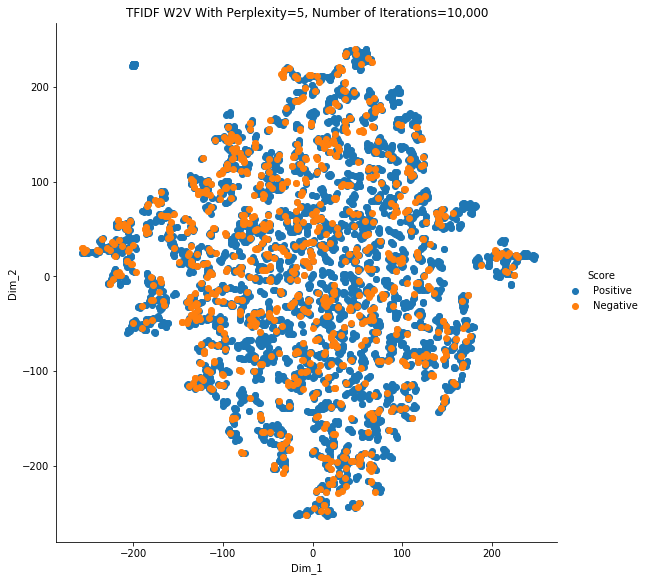

In [322]:
import seaborn as sns
sns.FacetGrid(data=TFIDF_W2V_DF1,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF W2V With Perplexity=5, Number of Iterations=10,000")
plt.show()

# TSNE on TFIDF W2V : Perplexity = 30, Number of Iterations = 10,000

In [317]:
TFIDF_W2V_model2 = TSNE(n_components=2,perplexity=30,n_iter=10000,n_iter_without_progress=1000,random_state=0)
TFIDF_W2V_TSNE2 = TFIDF_W2V_model2.fit_transform(standardized_tfidf_W2V)

In [318]:
print(TFIDF_W2V_TSNE2.shape)

(5979, 2)


In [319]:
TFIDF_W2V_TSNE2 = np.vstack((TFIDF_W2V_TSNE2.T,labels)).T

In [320]:
TFIDF_W2V_DF2 = pd.DataFrame(data=TFIDF_W2V_TSNE2,columns=("Dim_1","Dim_2","Score"))
print(TFIDF_W2V_DF2.head(5))
print(TFIDF_W2V_DF2.shape)

     Dim_1    Dim_2     Score
0 -97.3151  9.86962  Positive
1 -113.056  -1.7832  Positive
2  -113.27 -7.01147  Positive
3 -97.3651  6.45116  Positive
4 -83.1433  8.88114  Positive
(5979, 3)


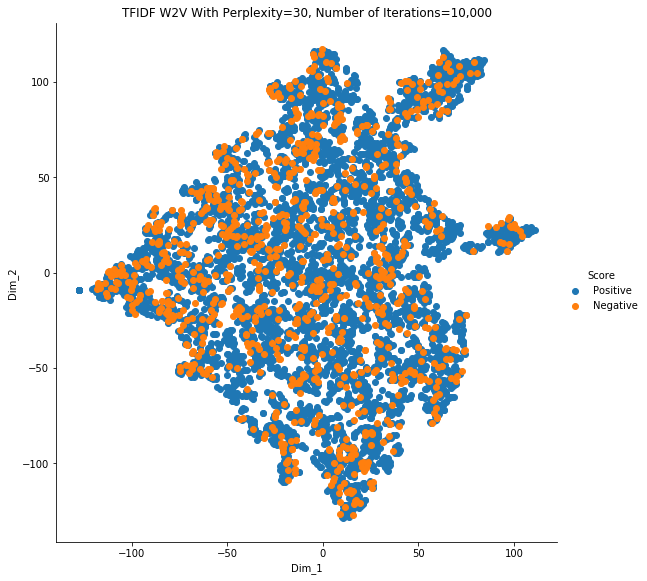

In [321]:
import seaborn as sns
sns.FacetGrid(data=TFIDF_W2V_DF2,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF W2V With Perplexity=30, Number of Iterations=10,000")
plt.show()

# TSNE on TFIDF W2V : Perplexity = 50, Number of Iterations = 10,000

In [323]:
TFIDF_W2V_model3 = TSNE(n_components=2,perplexity=50,n_iter=10000,n_iter_without_progress=1000,random_state=0)
TFIDF_W2V_TSNE3 = TFIDF_W2V_model3.fit_transform(standardized_tfidf_W2V)

In [338]:
print(TFIDF_W2V_TSNE3.shape)

(5979, 2)


In [339]:
TFIDF_W2V_TSNE3 = np.vstack((TFIDF_W2V_TSNE3.T,labels)).T

In [340]:
TFIDF_W2V_DF3 = pd.DataFrame(data=TFIDF_W2V_TSNE3,columns=("Dim_1","Dim_2","Score"))
print(TFIDF_W2V_DF3.head(5))
print(TFIDF_W2V_DF3.shape)

     Dim_1     Dim_2     Score
0 -70.4055   11.0237  Positive
1 -83.4556   3.06023  Positive
2  -82.546 -0.578869  Positive
3 -70.6545   9.26325  Positive
4 -60.8477   10.5309  Positive
(5979, 3)


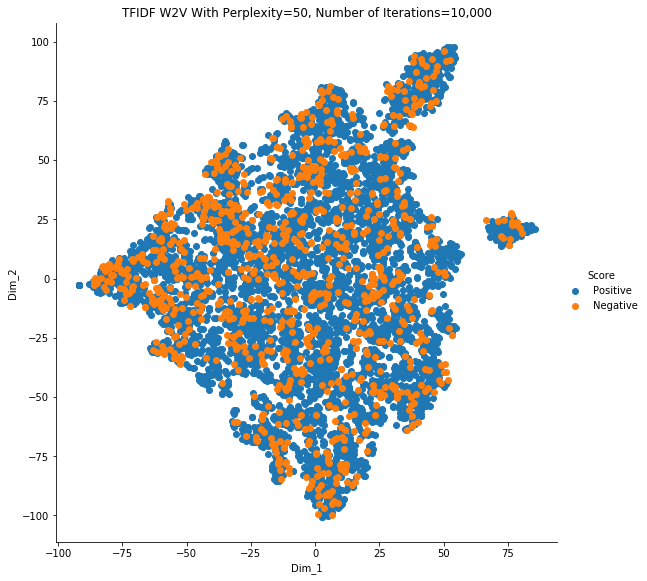

In [341]:
import seaborn as sns
sns.FacetGrid(data=TFIDF_W2V_DF3,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF W2V With Perplexity=50, Number of Iterations=10,000")
plt.show()

# TSNE on TFIDF W2V : Perplexity = 300, Number of Iterations = 10,000

In [348]:
TFIDF_W2V_model4 = TSNE(n_components=2,perplexity=300,n_iter=10000,n_iter_without_progress=1000,random_state=0)
TFIDF_W2V_TSNE4 = TFIDF_W2V_model4.fit_transform(standardized_tfidf_W2V)

In [343]:
print(TFIDF_W2V_TSNE4.shape)

(5979, 2)


In [344]:
TFIDF_W2V_TSNE4 = np.vstack((TFIDF_W2V_TSNE4.T,labels)).T

In [345]:
TFIDF_W2V_DF4 = pd.DataFrame(data=TFIDF_W2V_TSNE4,columns=("Dim_1","Dim_2","Score"))
print(TFIDF_W2V_DF4.head(5))
print(TFIDF_W2V_DF4.shape)

     Dim_1     Dim_2     Score
0 -16.5302   2.70335  Positive
1 -19.7045  0.443693  Positive
2 -19.2921 -0.301393  Positive
3 -16.7848   1.91259  Positive
4 -14.7718   1.92484  Positive
(5979, 3)


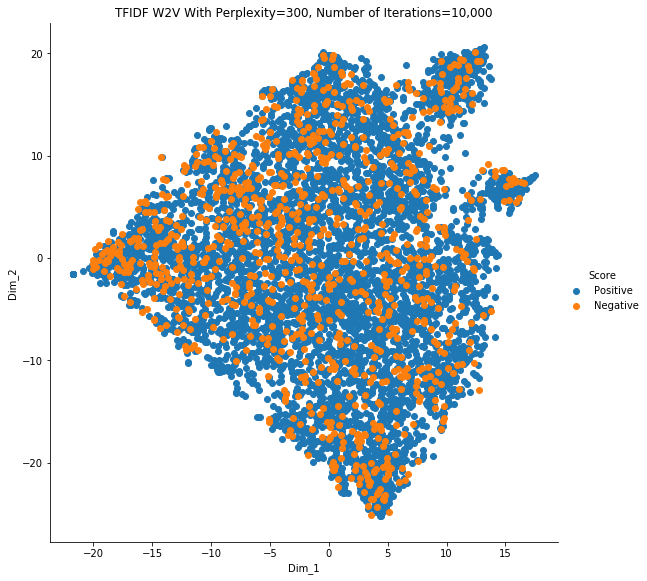

In [346]:
import seaborn as sns
sns.FacetGrid(data=TFIDF_W2V_DF4,hue='Score',height=8).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TFIDF W2V With Perplexity=300, Number of Iterations=10,000")
plt.show()

# [6] Conclusions

*We always need to apply TSNE more than once for multiple values of perplexity as well as step size. There's no way to ascertain the best value for perplexity but the plots are generally tried with perplexity values between 5 and 50. However, a perplexity value = 5 % of datasize could also be tried out.

*You should almost never look at small perplexity values such as 5 because TSNE tries to prserve the 5 Nearest Neighbours for each point which may show some pattern in data which may not be present in the higher dimensional 
dataset. 

*We can fix a large value of step size and then exit from the iterative loop in case for a particular value that we 
specify, there's no change in the visualization for that many iterations. In TSNE, this is carried out with the help
of n_iter_without_progress parameter.

1. In the BOW Representation, for all the different values of perplexity that I have tried out, both the positive as
well as the negative datapoints are present throughout with no pattern present for the separation between the 2 classes. Both the negative as well as positive reviews can have the same words but the issue lies because the semantic meaning of words is not taken into consideration.

2. For the TFIDF representation, there is some circular pattern obtained for the various values of perplexity ie. 
perplexity = 30, 50 or 300. This means that these values of perplexity basically make sense for these many number of
iterations. Here also, the issue is that the semantic meaning of words isn't taken into consideration. 

3. For the Avg Word2Vec Representation, the pattern obtained is roughly the same for various values of perplexity ie perplexity = 30, 50 as well as 300. This means that these values of perplexity as defined in the TSNE model make sense for these many iterations. 

4. Similarly for the TFIDF Word2Vec Representation we obtain an overalapping pattern which is because I have only taken 6k datapoints for my analysis. If I had taken the entire dataset, the datapoints of the 2 classes would have been that much separated. 

5. Both Avg Word2Vec as well as TFIDF weighted Word2Vec take the semantic meaning of words into consideration. If the data size was huge, like the Google News Dataset, the relationships would have been that much more evident if the specified dimensionality was much higher, such as 300, instead of 50 in our case.  

6. Word2Vec is the best model out of all these followed by Text TFIDF and lastly BOW representation.